In the previous chapter on multilevel modeling, our adaptive priors allowed us to use data about one subgroup of the data to learn about other groups. However, that knowledge transfer was limited to parameters of the same type. Like in the chimpanzee example, all of our $\alpha_j$'s had one prior parametrized by $\bar{\alpha}$ and $\sigma_\alpha$, and all the $\gamma_j$'s were parametrized by a $\sigma_\gamma$. Learning something about $\alpha_1$ helped us learn a bit about $\alpha_2$, but nothing about $\gamma_2$. In real life, sometimes there are correlations between different types of variables that allow us to learn something about multiple types at the same time and squeeze more information from our data.

In [22]:
import sys, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Path, PathPatch
import seaborn as sns
import scipy.stats as stats
from scipy import interpolate
import torch
tt =  torch.tensor
import pyro
from pyro import poutine
from pyro.distributions import (
    MultivariateNormal, Normal, LKJCorrCholesky, LKJCholesky, Exponential, Bernoulli, Poisson, HalfNormal
)
from pyro.infer import Predictive
from pyro.ops.stats import waic, hpdi
import arviz as az
import xarray as xr
import networkx as nx

from utils import traceplot, train_nuts

from utils import unnest_samples2 as unnest_samples

torch.multiprocessing.set_sharing_strategy("file_system")
pyro.enable_validation()

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Sep 25 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

scipy     : 1.12.0
matplotlib: 3.9.0
networkx  : 3.1
numpy     : 1.26.4
xarray    : 2024.5.0
torch     : 2.3.0
pyro      : 1.9.1
arviz     : 0.17.1
pandas    : 2.2.2
seaborn   : 0.12.2
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]

Watermark: 2.4.3



In [24]:
def get_log_prob(mcmc, data, site_names):
    samples = mcmc.get_samples()
    model = mcmc.kernel.model
    # get number of samples
    N = [v.shape[0] for v in samples.values()]
    assert [n == N[0] for n in N]
    N = N[0]
    if isinstance(site_names, str):
        site_names = [site_names]
    # iterate over samples
    log_prob = torch.zeros(N, len(data[site_names[0]]))
    for i in range(N):
        # condition on samples and get trace
        s = {k: v[i] for k, v in samples.items()}
        for nm in site_names:
            s[nm] = data[nm]
        tr = poutine.trace(poutine.condition(model, data=s)).get_trace(data)
        # get pointwise log probability
        for nm in site_names:
            node = tr.nodes[nm]
            log_prob[i] += node["fn"].log_prob(node["value"])
    return log_prob

### Code 14.29 - 14.35

We will now explore multiple varying effects in the context of gift-giving among households in Nicaragua. We will build a "social relations model" (SRM) to determine the patterns of gift-giving among pairs of households.

In [25]:
kl_df = pd.read_csv("data/KosterLeckie.csv", sep=";")
kl_df.head()

,hidA,hidB,did,giftsAB,giftsBA,offset,drel1,drel2,drel3,drel4,dlndist,dass,d0125
0,1,2,1,0,4,0.000,0,0,1,0,-2.790,0.000,0
1,1,3,2,6,31,-0.003,0,1,0,0,-2.817,0.044,0
2,1,4,3,2,5,-0.019,0,1,0,0,-1.886,0.025,0
3,1,5,4,4,2,0.000,0,1,0,0,-1.892,0.011,0
4,1,6,5,8,2,-0.003,1,0,0,0,-3.499,0.022,0


In [26]:
kl_df[["hidA", "hidB", "did", "giftsAB", "giftsBA"]].head()

,hidA,hidB,did,giftsAB,giftsBA
0,1,2,1,0,4
1,1,3,2,6,31
2,1,4,3,2,5
3,1,5,4,4,2
4,1,6,5,8,2


In [27]:
print("# unique houses:", kl_df["hidA"].nunique())
print("# unique dyads:", kl_df["did"].nunique())

# unique houses: 24
# unique dyads: 300


Each house (which has a unique ID `hid`) part of (potentially) multiple _dyads_ (given by unique dyad ID `did`), or pairs. We will use a "social relations model" (SRM) to model the gift exchange. This model is essentially a Poisson regression on the number of gifts given by house $A$ to house $B$, where the linear model is a sum of some general intercept $\alpha$, a the giving tendency of some household $g_A$, the receiving tendency of some household $r_B$, and a dyad-specific rate that $A$ gives to $B$ $d_{AB}$:

$$
y_{A\rightarrow B} \sim \text{Poisson}(\lambda_{AB}) \\
\lambda_{AB} = \exp\left(\alpha + g_A + r_B + d_{AB}\right)
$$

The is also a corresponding model for the exchange in the other direction $y_{B\rightarrow A}$. So for each household $H$, we need two varying effects $g_H$ and $r_H$, and for each dyad $AB$ to varying effects $d_{AB}$ and $d_{BA}$. We also want to take into account any possible correlations within these groups, so we will use the following adaptive priors:

$$
\begin{pmatrix}g_i\\ r_i\end{pmatrix} \sim \text{Normal}\left(\begin{pmatrix}0\\0\end{pmatrix}, \begin{pmatrix}\sigma_g^2 & \sigma_g \sigma_r \rho_{gr} \\ \sigma_g \sigma_r \rho_{gr} & \sigma_r^2\end{pmatrix}\right) \\
\begin{pmatrix}d_{ij}\\ d_{ji}\end{pmatrix} \sim \text{Normal}\left(\begin{pmatrix}0\\0\end{pmatrix}, \begin{pmatrix}\sigma_d^2 & \sigma_d^2 \rho_{d} \\ \sigma_d^2 \rho_{d} & \sigma_r^2\end{pmatrix}\right)
$$

In [28]:
data = dict(
    N = len(kl_df),
    N_households = int(max(*[kl_df[k].max() for k in ("hidA", "hidB")])),
    did = tt(kl_df["did"].values-1).long(),
    hidA = tt(kl_df["hidA"].values-1).long(),
    hidB = tt(kl_df["hidB"].values-1).long(),
    giftsAB = tt(kl_df["giftsAB"].values).double(),
    giftsBA = tt(kl_df["giftsBA"].values).double(),
)

In [29]:
def model_m14_6(data, training=False):
    N, Nh = [data[k] for k in ("N", "N_households")]
    a = pyro.sample("α", Normal(0., 1.))
    # giving/receiving covariance matrix
    Rgr = pyro.sample("Rgr", LKJCholesky(2, tt(1.5)))
    σgr = pyro.sample("σgr", Exponential(1.).expand([2]))
    Sgr = (torch.diag(σgr) @ Rgr)
    # dyad covariance matrix
    Rd = pyro.sample("Rd", LKJCholesky(2, tt(1.5)))
    σd = pyro.sample("σd", Exponential(1.))
    Sd = (σd * Rd)
    zeros = torch.zeros(2).float()
    # individual house giving/receiving variables
    gr = pyro.sample("gr", MultivariateNormal(zeros, scale_tril=Sgr.float()).expand([Nh]))

    # dyad variables
    d = pyro.sample("d", MultivariateNormal(zeros, scale_tril=Sd.float()).expand([N]))
    
    # form the linear models
    A, B, did = [data[k] for k in ("hidA", "hidB", "did")]
    λAB = torch.exp(a + gr[A,0] + gr[B,1] + d[did,0])
    λBA = torch.exp(a + gr[B,0] + gr[A,1] + d[did,1])
    # observe outcomes
    if training:
        pyro.sample("giftsAB", Poisson(λAB), obs=data["giftsAB"])
        pyro.sample("giftsBA", Poisson(λBA), obs=data["giftsBA"])
    else:
        gAB = pyro.sample("giftsAB", Poisson(λAB))
        gBA = pyro.sample("giftsBA", Poisson(λBA))
        return torch.stack([gAB, gBA])

In [30]:
m14_6 = train_nuts(model_m14_6, data, 500, 1000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/1500 [00:00, ?it/s]/tmp/ipykernel_7372/4012063187.py:5: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Rgr = pyro.sample("Rgr", LKJCholesky(2, tt(1.5)))
/tmp/ipykernel_7372/4012063187.py:9: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  Rd = pyro.sample("Rd", LKJCholesky(2, tt(1.5)))
Sample: 100%|██████████| 1500/1500 [02:34,  9.69it/s, step size=1.04e-01, acc. prob=0.853]


There are several hundred parameters in this model, so if I show all of their summary statistics, it might be a bit overwhelming. Instead, let's first examine just the covariance structure of the adaptive priors for the giving/receiving and dyad groups:

In [31]:
s = {k: v for k, v in m14_6.get_samples().items() if k in ("Rgr", "σgr")}
s["Rgr"] = torch.einsum("ijk,ilk->ijl", s["Rgr"], s["Rgr"])
df = []
for k, v in unnest_samples(s, 2).items():
    q = pyro.ops.stats.quantile(v, [0.05, 0.95])
    df.append({
        "param": k,
        "mean": round(v.mean().item(), 2),
        "std": round(v.std().item(), 2),
        "median": round(v.median().item(), 2),
        "5.0%": round(q[0].item(), 2),
        "95.0%": round(q[1].item(), 2),
        "n_eff": round(pyro.ops.stats.effective_sample_size(v[None,:]).item(), 2)
    })
pd.DataFrame(df).set_index("param")

,mean,std,median,5.0%,95.0%,n_eff
param,,,,,,
Rgr[0][0],1.00,0.00,1.00,1.00,1.00,NaN
Rgr[0][1],-0.55,0.21,-0.57,-0.87,-0.17,203.41
Rgr[1][0],-0.55,0.21,-0.57,-0.87,-0.17,203.41
Rgr[1][1],1.00,0.00,1.00,1.00,1.00,927.70
σgr[0],0.83,0.13,0.82,0.63,1.05,625.49
σgr[1],0.41,0.09,0.40,0.27,0.57,198.86


We can see that there is a pretty sizable negative correlation between ("generalized") giving and receiving. This means that across dyads, those who give more tend to receive less. The standard deviation parameters show that there is also a lot more variability in giving than there is in receiving. Let's plot the giving/receiving effects for each household.

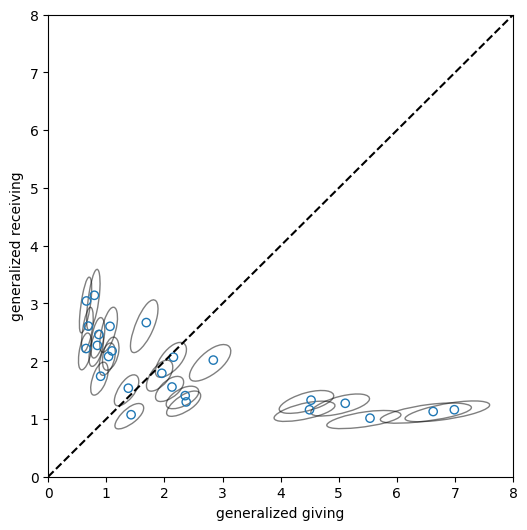

In [32]:
s = {k: v for k, v in m14_6.get_samples().items() if k in ("α", "gr")}
fig, ax = plt.subplots(figsize=(6, 6))
z = 2*np.sqrt(-2*np.log1p(-0.89)) # eigenvalue scaling factor to get 89% CI
for hid in range(data["N_households"]):
    g = s["α"] + s["gr"][:,hid,0]
    r = s["α"] + s["gr"][:,hid,1]
    plt.scatter(g.exp().mean(), r.exp().mean(), facecolor="none", edgecolor="C0")
    # make ellipse in unexponentiated space
    S = np.cov(torch.stack([g, r])) # covariance matrix
    w, v = np.linalg.eigh(S)
    angles = np.arctan2(*v) * (180/np.pi)
    idx = np.argmin(abs(angles))
    p = (g.mean(), r.mean())
    e = Ellipse(xy=p, width=z*w[idx], height=z*w[1-idx], angle=-angles[1-idx])
    # transform ellipse into exponentiated space
    path = e.get_transform().transform_path(e.get_path())
    path = Path(np.exp(path.vertices), path.codes)
    ax.add_patch(PathPatch(path, facecolor="none", edgecolor="black", alpha=0.5, zorder=-1))
#     sns.kdeplot(g.exp().numpy(), r.exp().numpy())
x = np.linspace(0, 8)
plt.plot(x, x, color="black", linestyle="--")
plt.xlim(left=0, right=8)
plt.ylim(bottom=0, top=8)
plt.xlabel("generalized giving")
plt.ylabel("generalized receiving")
plt.show()

We can see that there is indeed a negative correlation - houses that give the least recieve the most, and vice versa. Perhaps this is due to charity of the wealthy giving to those who need it the most (who can't afford to give themselves). Let's now take a look at how symmetric the dyad relationship is, controlling for the individual giving/receiving of each household.

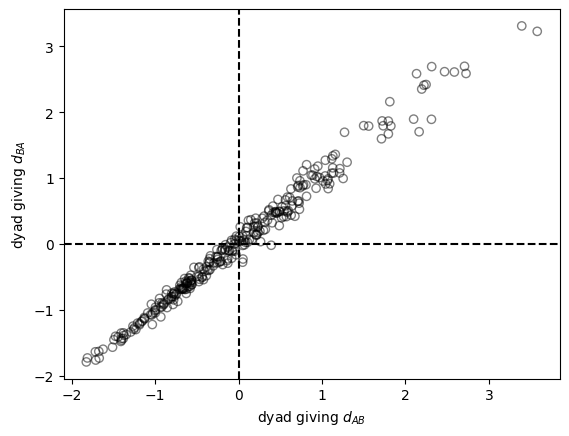

In [33]:
s = m14_6.get_samples()
dAB = s["d"][:,:,0].mean(dim=0)
dBA = s["d"][:,:,1].mean(dim=0)
plt.scatter(dAB, dBA, facecolor="none", edgecolor="black", alpha=0.5)
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("dyad giving $d_{AB}$")
plt.ylabel("dyad giving $d_{BA}$")
plt.show()

The relationship is super symmetric, but with a lot more variation than the giving/receiving log-rates. It seems that these people try to match the level of gift giving they recieve (accounting for individual levels of wealth, generosity, etc).

### Code 14.23 - 14.28
We have seen that covariance and correlation are useful when specifying hierarchical models with adaptive priors. However, it can be useful for much more than that. Consider a study where we want to determine the effect of education ($E$) on wages ($W$). If we just blindly regress $W$ on $E$, we could end up with a biased result when $E$ and $W$ are both influenced by some unobserved confounding factor ($U$).

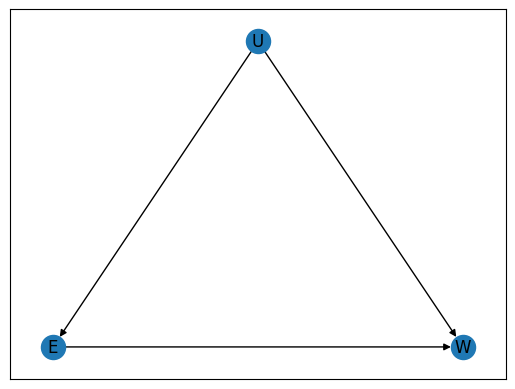

In [34]:
G = nx.DiGraph((("U","E"), ("U","W"), ("E","W")))
pos = {"E": (0, 0), "W": (1, 0), "U": (0.5, 0.5)}
nx.draw_networkx(G, pos); plt.show()

However, we can actually learn something about $U$ and tease out the actual effect of $E$ on $W$ by introducing an _instrumental variable_ $Q$, which only affects $E$, thereby turning it into a collider. (In the following example, $Q$ is a binary indicator that represents whether a subject was born during the first quarter of the year, the idea being that people born in Q1 will be older when they start school, and are eligible to drop out of school earlier.)

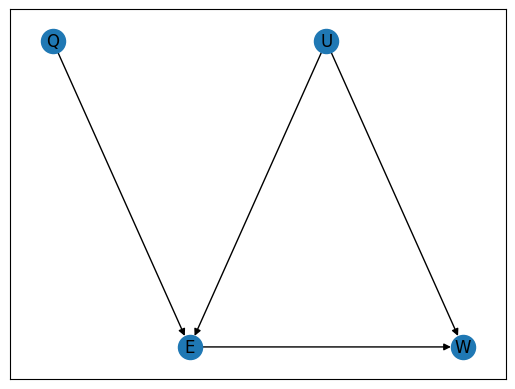

In [35]:
G = nx.DiGraph((("U","E"), ("U","W"), ("E","W"), ("Q", "E")))
pos = {"E": (0, 0), "W": (1, 0), "U": (0.5, 0.5), "Q": (-0.5, 0.5)}
nx.draw_networkx(G, pos); plt.show()

You can think of the instrumental variable (IV) as a light switch. A light $L$ being on depends on both the switch $S$ being turned on and the bulb $B$ being functional. If we turn on the switch but the light doesn't come on, then we can infer that the bulb must be broken. This is all possible because of the collider $S \rightarrow L \leftarrow B$.

We can create a generative model of this DAG and then re-learn its parameters to see the effect of the IV on our inference. Our ground-truth, generative model will be given by

$$\begin{align*}
W_i &\sim \text{Normal}(\mu_{W,i}, \sigma_W) \\
\mu_{W,i} &= \alpha_W + \beta_{EW} E_i + U_i \\
E_i &\sim \text{Normal}(\mu_{E,i}, \sigma_E) \\
\mu_{E,i} &= \alpha_E + \beta_{QE} Q_i + U_i \\
Q_i &\sim \text{Bernoulli}(0.25) \\
U_i &\sim \text{Normal}(0, 1)
\end{align*}$$

In [36]:
N = 500
U_sim = Normal(0., 1.).sample([N])
Q_sim = Bernoulli(0.25).sample([N])
E_sim = Normal(U_sim + Q_sim, 1.).sample()
W_sim = Normal(U_sim + 0*E_sim, 1.).sample()
data = dict(
    W = (W_sim - W_sim.mean())/W_sim.std(),
    E = (E_sim - E_sim.mean())/E_sim.std(),
    Q = (Q_sim - Q_sim.mean())/Q_sim.std(),
)

In [37]:
def model_m14_4(data, training=False):
    σ = pyro.sample("σ", Exponential(1.))
    αW = pyro.sample("αW", Normal(0., 0.2))
    βEW = pyro.sample("βEW", Normal(0., 0.5))
    μ = αW + βEW*data["E"]
    if training:
        pyro.sample("W", Normal(μ, σ), obs=data["W"])
    else:
        return pyro.sample("W", Normal(μ, σ))

In [38]:
m14_4 = train_nuts(model_m14_4, data, 500, 2000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 2500/2500 [00:04, 541.05it/s, step size=7.37e-01, acc. prob=0.926]


In [39]:
m14_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        αW     -0.00      0.04     -0.00     -0.06      0.07   1588.32      1.00
       βEW      0.49      0.04      0.49      0.43      0.56   1743.19      1.00
         σ      0.87      0.03      0.87      0.83      0.92   1739.39      1.00

Number of divergences: 0


We can see that this naiive model is very confident that $E$ has a strong positive effect on $W$. But we know better. Now, let's construct a smarter model that utilizes the IV $Q$.

$$\begin{align*}
\begin{pmatrix}W_i\\E_i\end{pmatrix} &\sim \text{Normal}\left(\begin{pmatrix}\mu_{W,i}\\\mu_{E_i}\end{pmatrix}, \boldsymbol{S}\right) \\
\mu_{W,i} &= \alpha_W + \beta_{EW} E_i \\
\mu_{E,i} &= \alpha_E + \beta_{QE} Q_i
\end{align*}$$

In [40]:
def model_m14_5(data, training=False):
    σ = pyro.sample("σ", Exponential(1.).expand([2]))
    R = pyro.sample("R", LKJCholesky(2, tt(1.)))
    S = torch.diag(σ) @ R
    α = pyro.sample("α", Normal(0., 0.2).expand([2]))
    β = pyro.sample("β", Normal(0., 0.5).expand([2]))
    WE, EQ = torch.stack([data["W"], data["E"]], dim=1), torch.stack([data["E"], data["Q"]], dim=1)
    μ = α[None,:] + β[None,:]*EQ
    if training:
        pyro.sample("WE", MultivariateNormal(μ, scale_tril=S), obs=WE)
    else:
        return pyro.sample("WE", MultivariateNormal(μ, scale_tril=S))

In [41]:
m14_5 = train_nuts(model_m14_5, data, 500, 2000, jit_compile=False)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 2500/2500 [00:59, 41.80it/s, step size=1.74e-01, acc. prob=0.941]


In [42]:
m14_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]      0.51      0.10      0.52      0.35      0.68       nan      1.00
    R[1,1]      0.85      0.06      0.86      0.77      0.96       nan      1.00
      α[0]     -0.00      0.04     -0.00     -0.07      0.07   1262.23      1.00
      α[1]     -0.00      0.04     -0.00     -0.07      0.07   1327.94      1.00
      β[0]      0.00      0.14      0.01     -0.24      0.21    486.58      1.00
      β[1]      0.30      0.04      0.30      0.23      0.37    926.87      1.00
      σ[0]      1.01      0.08      1.00      0.88      1.12    489.59      1.00
      σ[1]      0.96      0.03      0.95      0.91      1.01   1497.42      1.00

Number of divergences: 0


In [43]:
R = m14_5.get_samples()["R"]
torch.einsum("ijk,ilk->ijl", R, R).mean(dim=0)

tensor([[1.0000, 0.5081],
        [0.5081, 1.0000]])

We can see that the coefficient representing the effect of $E$ on $W$, $\beta_{EW}$ (`β[0]` in the code above) is consistent with zero, whereas the coefficient representing the effect of $Q$ on $E$, $\beta_{QE}$ (`β[1]` in the code) is decidedly positive. The correlation between $E$ and $W$ is also pretty high, as expected because of their relationship through the fork $E\leftarrow U \rightarrow W$.

Let's re-generate the data in a way such that the confounder $U$ is negatively correlated with $W$, and $E$ is very slightly positively correlated, so that the effect is that $U$ masks the influence of $E$.

In [44]:
N = 500
U_sim = Normal(0., 1.).sample([N])
Q_sim = Bernoulli(0.25).sample([N])
E_sim = Normal(U_sim + Q_sim, 1.).sample()
W_sim = Normal(-U_sim + 0.2*E_sim, 1.).sample()
data = dict(
    W = (W_sim - W_sim.mean())/W_sim.std(),
    E = (E_sim - E_sim.mean())/E_sim.std(),
    Q = (Q_sim - Q_sim.mean())/Q_sim.std(),
)

In [45]:
m14_5x = train_nuts(model_m14_5, data, 500, 2000, jit_compile=False)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 2500/2500 [00:52, 47.26it/s, step size=1.98e-01, acc. prob=0.931]


In [46]:
m14_5x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    R[0,0]      1.00      0.00      1.00      1.00      1.00       nan       nan
    R[0,1]      0.00      0.00      0.00      0.00      0.00       nan       nan
    R[1,0]     -0.50      0.11     -0.51     -0.68     -0.30       nan      1.00
    R[1,1]      0.86      0.07      0.86      0.75      0.96       nan      1.00
      α[0]     -0.00      0.05     -0.00     -0.07      0.08   1510.55      1.00
      α[1]     -0.00      0.04     -0.00     -0.07      0.07   1432.99      1.00
      β[0]      0.27      0.17      0.27     -0.03      0.54    505.32      1.00
      β[1]      0.27      0.04      0.27      0.20      0.33    996.37      1.00
      σ[0]      1.12      0.09      1.11      0.98      1.26    495.74      1.00
      σ[1]      0.97      0.03      0.96      0.92      1.02   1812.41      1.00

Number of divergences: 0


In [47]:
R = m14_5x.get_samples()["R"]
R = torch.einsum("ijk,ilk->ijl", R, R)
print("mean:")
print(R.mean(dim=0))
print("\nstd:")
print(R.std(dim=0))

mean:
tensor([[ 1.0000, -0.5015],
        [-0.5015,  1.0000]])

std:
tensor([[0.0000e+00, 1.1338e-01],
        [1.1338e-01, 4.3699e-08]])


$\beta_{EW}$ is still consistent with zero, but now has a slightly positive bias. We can also see from the correlation matrix that $E$ and $W$ are pretty strongly negatively correlated now. This is because $U$ positively influences $E$, and negatively influences $W$.

In the future, we can use a tool like [daggity](http://www.dagitty.net/) to help us figure out instrumental variables to use given a causal DAG.

The author also mentions that there is another useful technique for de-confounding known as the _front-door criterion_. Consider the the following DAG:

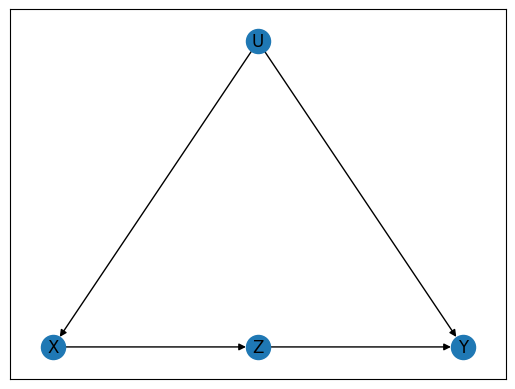

In [48]:
G = nx.DiGraph((("U", "X"), ("X", "Z"), ("Z", "Y"), ("U", "Y")))
pos = {"X": (0, 0), "Z": (1, 0), "Y": (2, 0), "U": (1, 1)}
nx.draw_networkx(G, pos); plt.show()

We can't directly estimate the effect of $X$ on $Y$ through regression because the unobserved $U$ acts as a confound. But through the front door path $X \rightarrow Z \rightarrow Y$, we can disentagle some of the effect of $U$. In the most extreme case, if $Z$ has zero influence on $Y$, then neither does $X$. In less extreme circumstances, we can combine the strength of $X \rightarrow Z$ and $Z \rightarrow Y$ to get a better estimate.